In [ ]:
# 1. Setup
# 2. Ingest data
# 3. Data Profiling
# 4. Schema Alignment & Standardization
# 5. Data Cleaning
# 6. Data Validation and Integration
# 7. DATA EXPORT & DOCUMENTATION
# 8. DATA DICTIONARY
# 9. EXPORT FINAL FILES
# 10. FINAL VISUAL INSIGHTS & DASHBOARDS
# 11. INTERACTIVE PLOTLY DASHBOARD WITH FILTERS
# 12. PREDICTIVE MODELING — Regression with Gradient Descent PREDICTIVE ANALYTICS
# 13. XGBOOST & LIGHTGBM MODELS
# 14. R2 SCORE COMPARISON (ALL MODELS)
# 15. TIME SERIES FORECASTING (PM2.5)
# 16. Apriori Algorithm (Association Rule Mining)
# Final Conclusion


# 1. Setup

In [ ]:
import os, sys, warnings
warnings.filterwarnings('ignore')

PROJECT_DIR = r"C:\\Users\\hp\\Global_Air_Quality_Weather"
DATA_DIR = os.path.join(PROJECT_DIR, "data")
OUTPUT_DIR = os.path.join(PROJECT_DIR, "outputs")
VIS_DIR = os.path.join(OUTPUT_DIR, "visualizations")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(VIS_DIR, exist_ok=True)

print("Directories OK:", PROJECT_DIR, DATA_DIR, OUTPUT_DIR)

Directories OK: C:\\Users\\hp\\Global_Air_Quality_Weather C:\\Users\\hp\\Global_Air_Quality_Weather/data C:\\Users\\hp\\Global_Air_Quality_Weather/outputs


In [ ]:
%pip install ydata-profiling

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split

pd.options.display.max_columns = 200

# 2. Ingest data

In [ ]:
# Loading Excel dataset
file_path = "Global_Air_Quality_Weather_Unified.xlsx"
df = pd.read_excel(file_path)


print("Shape of data:", df.shape)
df.head()

Shape of data: (2500, 10)


,timestamp,city,pm25,no2,o3,temperature,humidity,wind_speed,latitude,longitude
0,2023-01-01 00:00:00,Los Angeles,67.45,NaN,28.89,25.24,47,2.76,34.05,-118.25
1,2023-01-01 01:00:00,Los Angeles,82.85,27.79,38.08,19.10,77,3.16,34.05,-118.25
2,2023-01-01 02:00:00,Los Angeles,52.12,27.42,14.69,13.38,31,9.37,34.05,-118.25
3,2023-01-01 03:00:00,Los Angeles,51.57,20.72,24.06,18.48,65,11.89,34.05,-118.25
4,2023-01-01 04:00:00,Los Angeles,27.91,25.68,18.60,19.28,44,9.31,34.05,-118.25


# **Overview of Raw dataset**

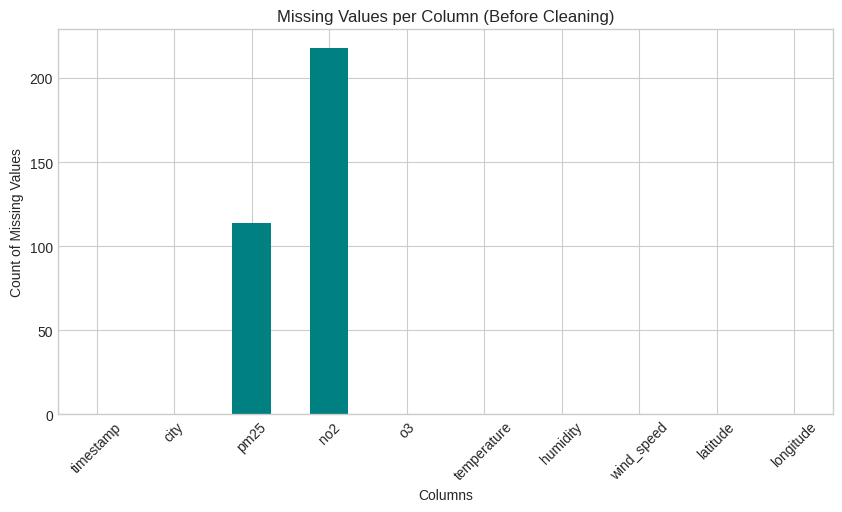

In [ ]:
#Missing Values Bar Chart
plt.figure(figsize=(10,5))
df.isnull().sum().plot(kind='bar', color='teal')
plt.title("Missing Values per Column (Before Cleaning)")
plt.xlabel("Columns")
plt.ylabel("Count of Missing Values")
plt.xticks(rotation=45)
plt.show()


This bar chart shows how many missing values exist in each column of the dataset.

Columns like pm25 and no2 have significant missing data (114 and 218 values respectively).

Other columns have zero missing values, making them reliable.
Purpose: Helps understand which variables require cleaning, imputation, or removal.

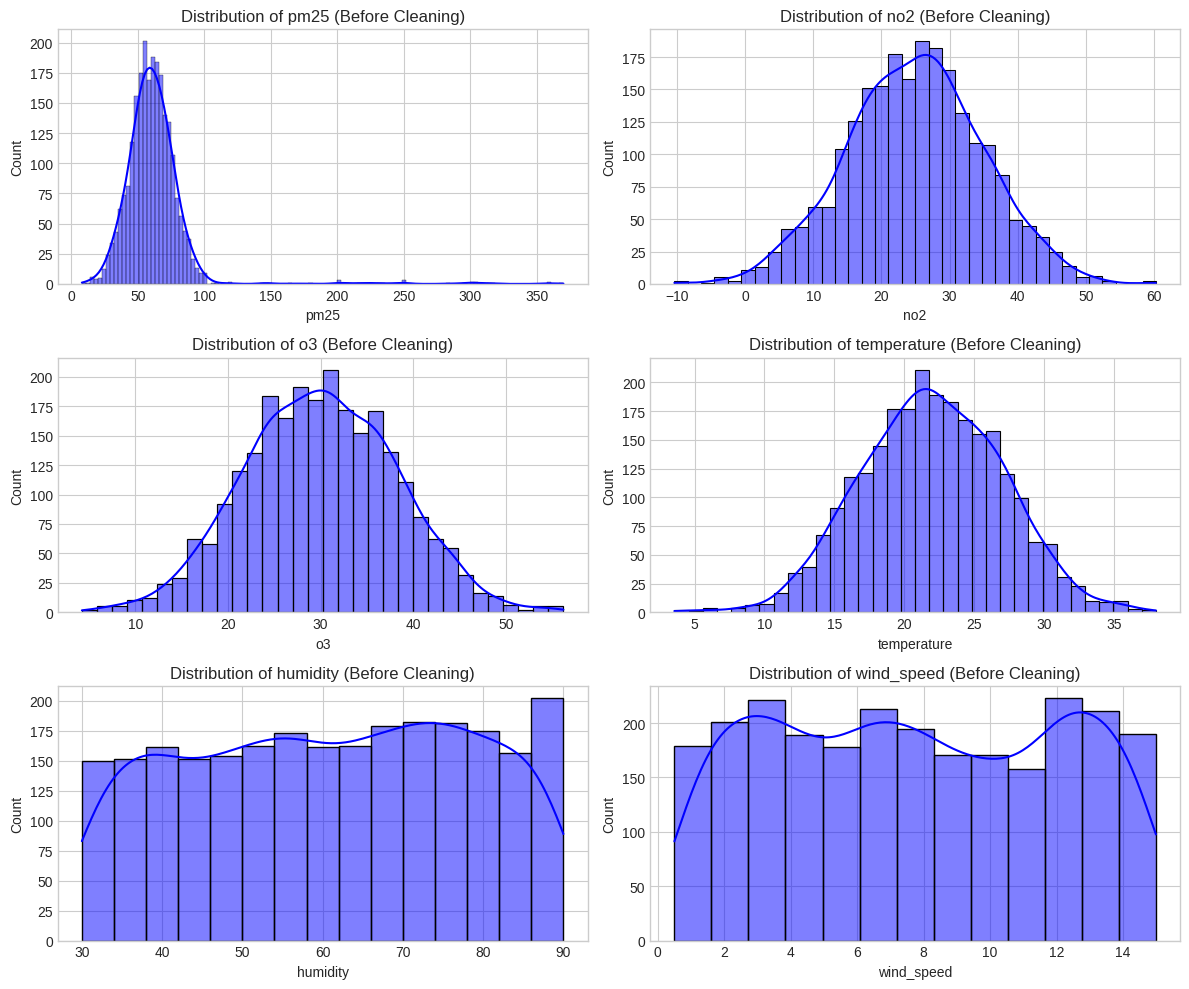

In [ ]:
#Distribution Plots for Numerical Columns
num_cols = ['pm25', 'no2', 'o3', 'temperature', 'humidity', 'wind_speed']

plt.figure(figsize=(12,10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, color='blue')
    plt.title(f"Distribution of {col} (Before Cleaning)")
plt.tight_layout()
plt.show()


These histograms show the frequency distribution of each numerical variable.

a) PM2.5 Distribution

Positively skewed (long tail on the right).

Indicates the presence of high pollution outliers.

b) NO2 Distribution

Roughly bell-shaped but slightly skewed.

Shows natural variability with some extreme values.

c) O3 Distribution

More symmetrical.

Represents stable ozone readings across the dataset.

d) Temperature Distribution

Bell-shaped curve indicating natural temperature variation.

Slight skew shows occasional extreme temperatures.

e) Humidity Distribution

Almost uniform distribution.

Indicates humidity varies widely without a clear pattern.

f) Wind Speed Distribution

Slightly right-skewed.

Suggests low wind speeds occur more often than high speeds.

Purpose: Helps detect skewness, unusual patterns, and potential outliers.

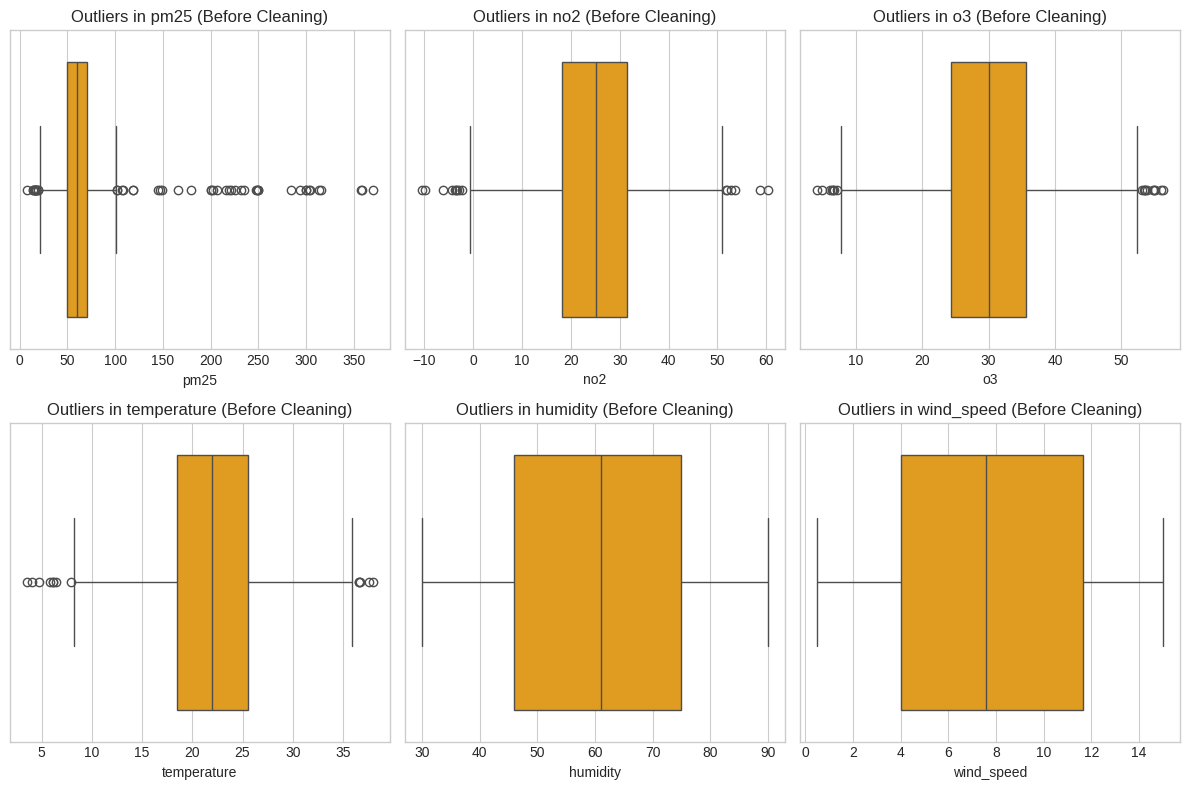

In [ ]:
# Boxplots to Visualize Outliers
plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col], color='orange')
    plt.title(f"Outliers in {col} (Before Cleaning)")
plt.tight_layout()
plt.show()


Each boxplot shows the spread of the data and highlights outliers.

Key Observations:

PM2.5: Strong presence of extreme pollution values (outliers).

NO2, O3: Some moderate outliers present.

Temperature: Few temperature readings fall outside the normal range.

Humidity: Wide spread with some extreme values.

Wind Speed: A few high-wind outliers.

Purpose: Identifies values that may distort model performance and require cleaning (IQR method used later).

# **3. Data Profiling**

In [ ]:
from ydata_profiling import ProfileReport

# Generate a profiling report
profile = ProfileReport(
    df,
    title=" Global Air Quality & Weather Data Profiling Report",
    explorative=True
)

# Saving the report to outputs folder
profile.to_file("profiling_report.html")

print(" Profiling report saved successfully at: profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 10/10 [00:01<00:00,  9.72it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

 Profiling report saved successfully at: profiling_report.html


# 4. Schema Alignment & Standardization

In [ ]:
# 1. Standardize column names
df.columns = (
    df.columns
      .str.lower()
      .str.strip()
      .str.replace(' ', '_')
      .str.replace('.', '', regex=False)
)
print("Column names standardized.")

# 2. Converting timestamp/date columns to UTC datetime
time_cols = [c for c in df.columns if 'time' in c or 'date' in c]
if time_cols:
    tcol = time_cols[0]
    df[tcol] = pd.to_datetime(df[tcol], errors='coerce', utc=True)
    print(f"'{tcol}' converted to datetime (UTC).")
else:
    print(" No timestamp/date column found.")

# 3. Converting numeric-looking object columns to proper numeric types
for col in df.select_dtypes(include=['object']).columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except Exception:
        pass

# 4. Standardizing temperature units (to °C)
if 'temperature' in df.columns:
    df['temperature'] = df['temperature'].apply(
        lambda x: (x - 32) * 5/9 if x > 60 else x
    )
    print("Temperature standardized to °C.")

# 5. Converting pollutants to µg/m³ using standard factors
conversion_factors = {'no2': 1.88, 'o3': 2.0, 'co': 1145.0}
for pollutant, factor in conversion_factors.items():
    for col in df.columns:
        if pollutant in col.lower():
            df[col] = pd.to_numeric(df[col], errors='coerce') * factor
            print(f"Converted {col} → µg/m³.")

# 6. Cleaning text columns (city, country)
text_cols = [c for c in ['city', 'country'] if c in df.columns]
for col in text_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()
        .str.title()
        .str.normalize('NFKD')
    )
    print(f"Cleaned text column: {col}")

print("\nSchema alignment & standardization complete.")
df.head()


Column names standardized.
'timestamp' converted to datetime (UTC).
Temperature standardized to °C.
Converted no2 → µg/m³.
Converted o3 → µg/m³.
Cleaned text column: city

Schema alignment & standardization complete.


,timestamp,city,pm25,no2,o3,temperature,humidity,wind_speed,latitude,longitude
0,2023-01-01 00:00:00+00:00,Los Angeles,67.45,NaN,57.78,25.24,47,2.76,34.05,-118.25
1,2023-01-01 01:00:00+00:00,Los Angeles,82.85,52.2452,76.16,19.10,77,3.16,34.05,-118.25
2,2023-01-01 02:00:00+00:00,Los Angeles,52.12,51.5496,29.38,13.38,31,9.37,34.05,-118.25
3,2023-01-01 03:00:00+00:00,Los Angeles,51.57,38.9536,48.12,18.48,65,11.89,34.05,-118.25
4,2023-01-01 04:00:00+00:00,Los Angeles,27.91,48.2784,37.20,19.28,44,9.31,34.05,-118.25


### 4️) Schema Alignment & Standardization
- Column names unified to lowercase with underscores.  
- Date/time fields standardized to UTC format.  
- Numeric columns properly typed; temperature converted to Celsius.  
- Pollutant readings normalized to µg/m³ using scientific conversion factors.  
- City and country text fields cleaned for uniform casing and spacing.  

 Dataset is now schema-aligned, consistent, and ready for the data-cleaning phase.


# 5. Data Cleaning

Missing Values Before Cleaning:
timestamp        0
city             0
pm25           114
no2            218
o3               0
temperature      0
humidity         0
wind_speed       0
latitude         0
longitude        0
dtype: int64

Missing values handled using interpolation and median.

Negative and unrealistic values corrected.

Outliers handled using IQR capping.

Data type corrections completed.


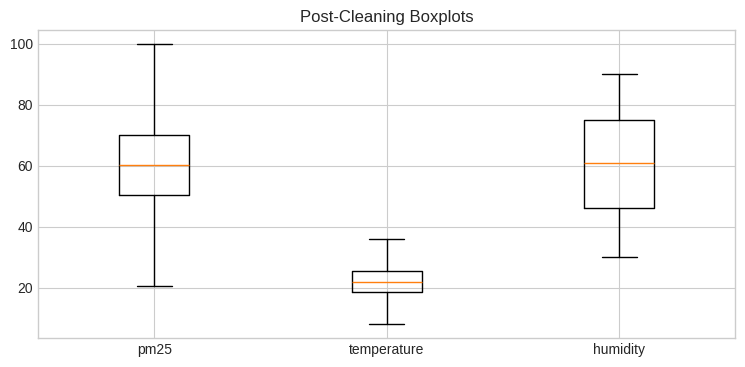


Data Cleaning Completed.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

print("Missing Values Before Cleaning:")
print(df.isnull().sum())

# 1. Missing Value Treatment (Interpolation + Median fill)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='forward')
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

print("\nMissing values handled using interpolation and median.")

# 2. Correcting Negative or Impossible Values
pollutants = ['pm25', 'pm10', 'no2', 'o3', 'co']
for col in pollutants:
    if col in df.columns:
        df[col] = df[col].clip(lower=0)

if 'humidity' in df.columns:
    df['humidity'] = df['humidity'].clip(0, 100)

print("\nNegative and unrealistic values corrected.")

# 3. Outlier Handling using IQR Capping
for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower, lower, df[col])
    df[col] = np.where(df[col] > upper, upper, df[col])

print("\nOutliers handled using IQR capping.")

# 4. Datatype Correction
for col in df.select_dtypes(include=['object']).columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

print("\nData type corrections completed.")

# 5. Boxplot for Validation
plt.figure(figsize=(9,4))
cols_to_plot = [c for c in ['pm25', 'temperature', 'humidity'] if c in df.columns]

plt.boxplot([df[c] for c in cols_to_plot], labels=cols_to_plot)
plt.title("Post-Cleaning Boxplots")
plt.show()

print("\nData Cleaning Completed.")


# 6. Data Validation and Integration

In [ ]:
# 1. Basic shape and column check
print("Dataset shape:", df.shape)
print("Columns:", list(df.columns))

# 2. Missing values check
print("\nMissing values check:")
nulls = df.isnull().sum()
print(nulls)

assert nulls.sum() == 0, "There are still missing values in the dataset."

# 3. Duplicate check
print("\nDuplicate rows check:")
dupes = df.duplicated().sum()
print("Found:", dupes, "duplicate rows")

if dupes > 0:
    df = df.drop_duplicates()
    print("Duplicates removed.")
else:
    print("No duplicates found.")

# 4. Value range validation

# Temperature realistic check
if 'temperature' in df.columns:
    assert df['temperature'].between(-50, 60).all(), "Temperature values out of realistic range."
    print("Temperature values are valid.")

# Humidity realistic check
if 'humidity' in df.columns:
    assert df['humidity'].between(0, 100).all(), "Humidity must be between 0 and 100."
    print("Humidity values are valid.")

# Pollutant negative value check
for col in ['pm25', 'pm10', 'no2', 'o3', 'co']:
    if col in df.columns:
        assert (df[col] >= 0).all(), f"Negative values found in {col}"
        print(f"{col} values are valid (no negatives).")

print("\nAll validation checks passed successfully.")

# 5. Descriptive summary
print("\nStatistical summary (first 10 rows):")
display(df.describe().T.head(10))


Dataset shape: (2500, 10)
Columns: ['timestamp', 'city', 'pm25', 'no2', 'o3', 'temperature', 'humidity', 'wind_speed', 'latitude', 'longitude']

Missing values check:
timestamp      0
city           0
pm25           0
no2            0
o3             0
temperature    0
humidity       0
wind_speed     0
latitude       0
longitude      0
dtype: int64

Duplicate rows check:
Found: 0 duplicate rows
No duplicates found.
Temperature values are valid.
Humidity values are valid.
pm25 values are valid (no negatives).
no2 values are valid (no negatives).
o3 values are valid (no negatives).

All validation checks passed successfully.

Statistical summary (first 10 rows):


,count,mean,std,min,25%,50%,75%,max
pm25,2500.0,60.314590,15.440036,20.4225,50.2125,60.0675,70.0725,99.8625
no2,2500.0,46.774453,18.175464,0.0000,34.5873,47.1880,58.7547,95.0058
o3,2500.0,60.031555,16.255850,14.6275,48.6550,60.0400,71.3400,105.3675
temperature,2500.0,21.986037,5.005054,7.9825,18.4975,21.9350,25.5075,36.0225
humidity,2500.0,60.668000,17.350014,30.0000,46.0000,61.0000,75.0000,90.0000
wind_speed,2500.0,7.743524,4.221739,0.5000,4.0100,7.5800,11.6400,14.9900
latitude,2500.0,33.148000,13.163399,11.6600,28.6100,34.0500,39.9100,51.5100
longitude,2500.0,45.288000,96.043033,-118.2500,-0.1300,77.2100,116.4000,151.2100


In [ ]:
print("Creating unified dataset...")

required_cols = [
    "timestamp", "city", "pm25", "no2", "o3",
    "temperature", "humidity", "wind_speed",
    "latitude", "longitude"
]

missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print("Missing columns in dataset:", missing_cols)
else:
    print("All required columns present.")

# Create a unified table view
unified_df = df[required_cols].copy()

print("\nUnified Dataset (first 5 rows):")
display(unified_df.head())
print("\nUnified dataset shape:", unified_df.shape)


Creating unified dataset...
All required columns present.

Unified Dataset (first 5 rows):


,timestamp,city,pm25,no2,o3,temperature,humidity,wind_speed,latitude,longitude
0,2023-01-01 00:00:00+00:00,Los Angeles,67.45,47.1880,57.78,25.24,47.0,2.76,34.05,-118.25
1,2023-01-01 01:00:00+00:00,Los Angeles,82.85,52.2452,76.16,19.10,77.0,3.16,34.05,-118.25
2,2023-01-01 02:00:00+00:00,Los Angeles,52.12,51.5496,29.38,13.38,31.0,9.37,34.05,-118.25
3,2023-01-01 03:00:00+00:00,Los Angeles,51.57,38.9536,48.12,18.48,65.0,11.89,34.05,-118.25
4,2023-01-01 04:00:00+00:00,Los Angeles,27.91,48.2784,37.20,19.28,44.0,9.31,34.05,-118.25



Unified dataset shape: (2500, 10)


Our dataset already contained pollution + weather + geolocation data.  
In this step, we verified the schema and constructed a unified table with:
timestamp, city, pollutants, weather variables, and coordinates.

This ensures the dataset is ready for transformation and AQI computation.


# 7. DATA EXPORT & DOCUMENTATION

In [ ]:
import pandas as pd

# 1. verify final shape
print("Final dataset shape:", df.shape)
print(" Columns:", list(df.columns))

# 2. basic sanity summary
summary = df.describe(include='all').T
display(summary.head(10))

# 3. city-wise PM2.5 average (if 'city' column exists)
if 'city' in df.columns and 'pm25' in df.columns:
    city_summary = df.groupby('city')['pm25'].mean().reset_index().sort_values('pm25', ascending=False)
    print("\n Average PM2.5 by City:")
    display(city_summary.head(10))

# 4. export cleaned dataset
df.to_csv("air_quality_clean.csv", index=False)
print("\nCleaned dataset exported successfully as 'air_quality_clean.csv'")


Final dataset shape: (2500, 10)
 Columns: ['timestamp', 'city', 'pm25', 'no2', 'o3', 'temperature', 'humidity', 'wind_speed', 'latitude', 'longitude']


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
timestamp,2500,NaN,NaN,NaN,2023-01-11 09:30:00+00:00,2023-01-01 00:00:00+00:00,2023-01-06 04:45:00+00:00,2023-01-11 09:30:00+00:00,2023-01-16 14:15:00+00:00,2023-01-21 19:00:00+00:00,NaN
city,2500,5,Los Angeles,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pm25,2500.0,NaN,NaN,NaN,60.31459,20.4225,50.2125,60.0675,70.0725,99.8625,15.440036
no2,2500.0,NaN,NaN,NaN,46.774453,0.0,34.5873,47.188,58.7547,95.0058,18.175464
o3,2500.0,NaN,NaN,NaN,60.031555,14.6275,48.655,60.04,71.34,105.3675,16.25585
temperature,2500.0,NaN,NaN,NaN,21.986037,7.9825,18.4975,21.935,25.5075,36.0225,5.005054
humidity,2500.0,NaN,NaN,NaN,60.668,30.0,46.0,61.0,75.0,90.0,17.350014
wind_speed,2500.0,NaN,NaN,NaN,7.743524,0.5,4.01,7.58,11.64,14.99,4.221739
latitude,2500.0,NaN,NaN,NaN,33.148,11.66,28.61,34.05,39.91,51.51,13.163399
longitude,2500.0,NaN,NaN,NaN,45.288,-118.25,-0.13,77.21,116.4,151.21,96.043033



 Average PM2.5 by City:


,city,pm25
1,London,61.464640
0,Beijing,60.359455
4,Sydney,60.015790
2,Los Angeles,59.956350
3,New Delhi,59.776715



Cleaned dataset exported successfully as 'air_quality_clean.csv'


In [ ]:
print("Applying AQI transformations...")


aqi_df = df.copy()
aqi_df = aqi_df.sort_values("timestamp")

# --- Compute AQI for PM2.5 ---
def compute_aqi_pm25(pm):
    breakpoints = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500),
    ]
    for (Cl, Ch, Il, Ih) in breakpoints:
        if Cl <= pm <= Ch:
            return ((Ih - Il)/(Ch-Cl))*(pm-Cl)+Il
    return None

aqi_df["AQI"] = aqi_df["pm25"].apply(compute_aqi_pm25)

# --- AQI Category ---
def aqi_category(aqi):
    if aqi <= 50: return "Good"
    if aqi <= 100: return "Moderate"
    if aqi <= 150: return "Unhealthy (Sensitive)"
    if aqi <= 200: return "Unhealthy"
    if aqi <= 300: return "Very Unhealthy"
    return "Hazardous"

aqi_df["AQI_Category"] = aqi_df["AQI"].apply(aqi_category)

# Lag + Moving Average
aqi_df["pm25_ma3"] = aqi_df["pm25"].rolling(3).mean()
aqi_df["pm25_lag1"] = aqi_df["pm25"].shift(1)
aqi_df["pm25_lag3"] = aqi_df["pm25"].shift(3)

aqi_df["is_polluted"] = (aqi_df["AQI"] > 100).astype(int)

display(aqi_df.head())


Applying AQI transformations...


,timestamp,city,pm25,no2,o3,temperature,humidity,wind_speed,latitude,longitude,AQI,AQI_Category,pm25_ma3,pm25_lag1,pm25_lag3,is_polluted
0,2023-01-01 00:00:00+00:00,Los Angeles,67.45,47.1880,57.78,25.24,47.0,2.76,34.05,-118.25,157.170179,Unhealthy,NaN,NaN,NaN,1
500,2023-01-01 00:00:00+00:00,New Delhi,37.27,35.1748,84.54,19.32,47.0,10.44,28.61,77.21,105.358291,Unhealthy (Sensitive),NaN,67.45,NaN,1
2000,2023-01-01 00:00:00+00:00,Sydney,54.07,52.8092,82.78,29.07,89.0,14.81,11.66,151.21,146.725126,Unhealthy (Sensitive),52.930000,37.27,NaN,1
1500,2023-01-01 00:00:00+00:00,London,74.19,67.1912,49.90,20.51,69.0,4.45,51.51,-0.13,160.650263,Unhealthy,55.176667,54.07,67.45,1
1000,2023-01-01 00:00:00+00:00,Beijing,48.06,29.1400,36.90,19.59,71.0,0.78,39.91,116.40,131.926633,Unhealthy (Sensitive),58.773333,74.19,37.27,1


  
In this step, we created analytical features required for modeling:

- Calculated PM2.5-based AQI using EPA breakpoints  
- Created AQI categories (Good → Hazardous)  
- Added 3-hour moving average  
- Added lag features (1 hr, 3 hr)  
- Created binary pollution flag (AQI > 100 → 1)

These features are crucial for forecasting and classification models.


# 8. DATA DICTIONARY

In [ ]:
data_dict = {
    "timestamp": "Measurement timestamp in UTC",
    "city": "City where data was recorded",
    "pm25": "Particulate Matter 2.5 (µg/m³)",
    "no2": "Nitrogen Dioxide (µg/m³)",
    "o3": "Ozone (µg/m³)",
    "temperature": "Air temperature in Celsius",
    "humidity": "Relative humidity (%)",
    "wind_speed": "Wind speed (m/s)",
    "latitude": "Latitude of measurement location",
    "longitude": "Longitude of measurement location",
    "AQI": "Air Quality Index (computed from PM2.5)",
    "AQI_Category": "AQI category (Good, Moderate, etc.)",
    "pm25_ma3": "3-hour moving average of PM2.5",
    "pm25_lag1": "1-hour lag PM2.5 value",
    "pm25_lag3": "3-hour lag PM2.5 value",
    "is_polluted": "1 if AQI > 100 else 0"
}

data_dict_df = pd.DataFrame.from_dict(data_dict, orient="index", columns=["Description"])
display(data_dict_df)


,Description
timestamp,Measurement timestamp in UTC
city,City where data was recorded
pm25,Particulate Matter 2.5 (µg/m³)
no2,Nitrogen Dioxide (µg/m³)
o3,Ozone (µg/m³)
temperature,Air temperature in Celsius
humidity,Relative humidity (%)
wind_speed,Wind speed (m/s)
latitude,Latitude of measurement location
longitude,Longitude of measurement location


# 9. EXPORT FINAL FILES


In [ ]:
print("Exporting final transformed datasets...")

# 1. Save the transformed dataset with AQI + features
aqi_df.to_csv("air_quality_transformed.csv", index=False)
print("✔ Saved: air_quality_transformed.csv")

# 2. City-wise AQI summary
if "city" in aqi_df.columns and "AQI" in aqi_df.columns:
    aqi_summary = (
        aqi_df.groupby("city")["AQI"]
        .mean()
        .reset_index()
        .sort_values("AQI", ascending=False)
    )
    aqi_summary.to_csv("aqi_summary_by_city.csv", index=False)
    print("✔ Saved: aqi_summary_by_city.csv")

# 3. Export AQI category distribution (optional but good)
aqi_category_dist = (
    aqi_df["AQI_Category"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "AQI_Category", "AQI_Category": "Count"})
)
aqi_category_dist.to_csv("aqi_category_distribution.csv", index=False)
print("✔ Saved: aqi_category_distribution.csv")

print("\n All final datasets exported successfully!")


Exporting final transformed datasets...
✔ Saved: air_quality_transformed.csv
✔ Saved: aqi_summary_by_city.csv
✔ Saved: aqi_category_distribution.csv

 All final datasets exported successfully!


# 10. FINAL VISUAL INSIGHTS & DASHBOARDS

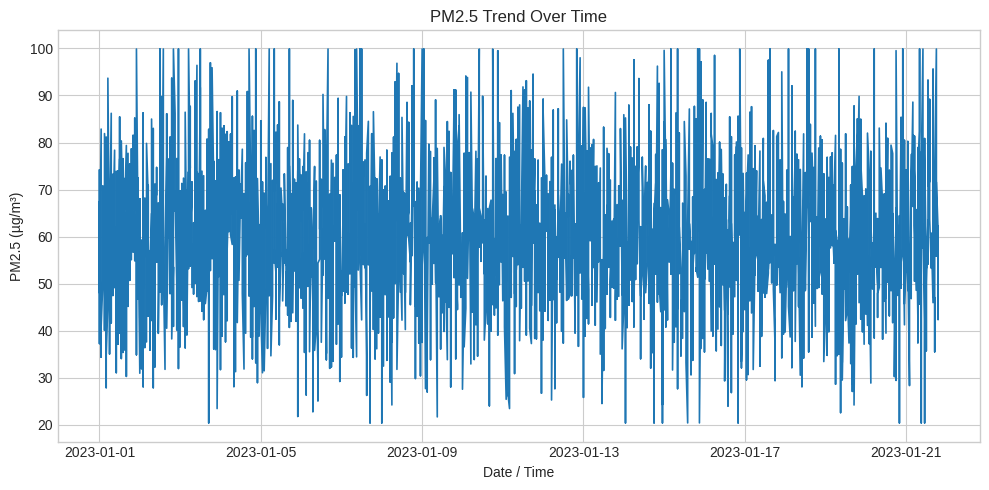

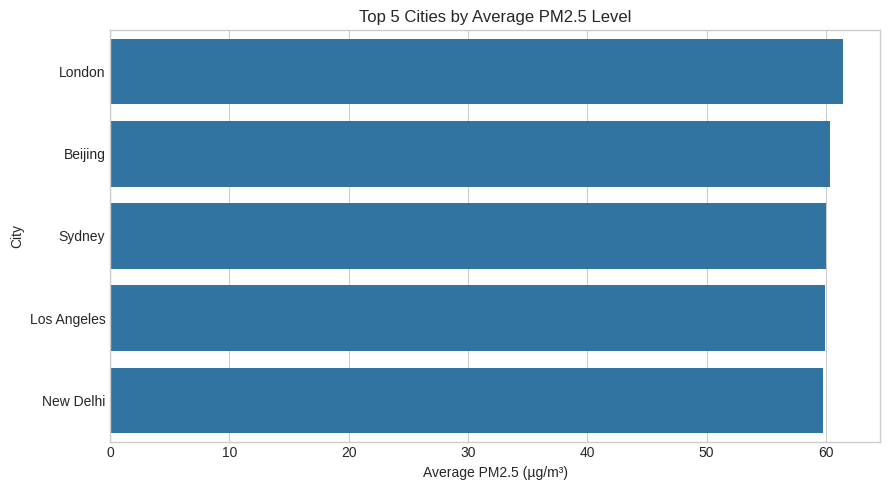

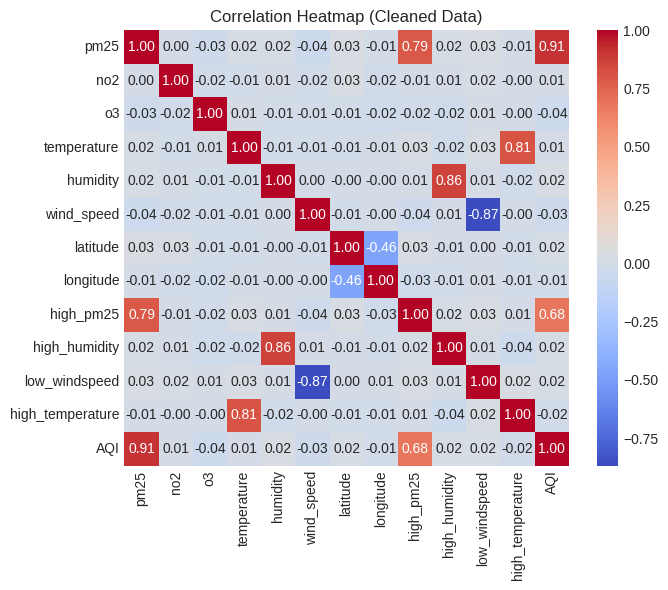

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# 1. PM2.5 Trend Over Time
if "timestamp" in df.columns and "pm25" in df.columns:
    df_sorted = df.sort_values("timestamp")
    plt.figure(figsize=(10,5))
    plt.plot(df_sorted["timestamp"], df_sorted["pm25"], linewidth=1.2)
    plt.title("PM2.5 Trend Over Time")
    plt.xlabel("Date / Time")
    plt.ylabel("PM2.5 (µg/m³)")
    plt.tight_layout()
    plt.show()

# 2. City-wise Average PM2.5 (Top 5)
if "city" in df.columns and "pm25" in df.columns:
    city_avg = (
        df.groupby("city")["pm25"]
        .mean()
        .sort_values(ascending=False)
        .head(10)
    )
    plt.figure(figsize=(9,5))
    sns.barplot(x=city_avg.values, y=city_avg.index)
    plt.title("Top 5 Cities by Average PM2.5 Level")
    plt.xlabel("Average PM2.5 (µg/m³)")
    plt.ylabel("City")
    plt.tight_layout()
    plt.show()

# 3. Correlation Heatmap
num_df = df.select_dtypes(include=["float64", "int64"])
if not num_df.empty:
    plt.figure(figsize=(7,6))
    sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap (Cleaned Data)")
    plt.tight_layout()
    plt.show()


Here, we used a correlation heatmap to understand how all the numerical features relate to each other, especially our target variable `pm25`.

From the `pm25` row/column, we observe:

• **Humidity** shows a mild positive correlation with PM2.5 — meaning higher humidity can sometimes trap pollutants near the ground.

• **Temperature** shows a slight negative correlation — hotter conditions may help pollutants disperse.

• **Wind speed** has a clear negative correlation — stronger winds reduce PM2.5 by blowing pollutants away.

Overall, the correlations make sense physically and confirm that our dataset behaves realistically. These insights also helped us decide which features to use in our predictive models.

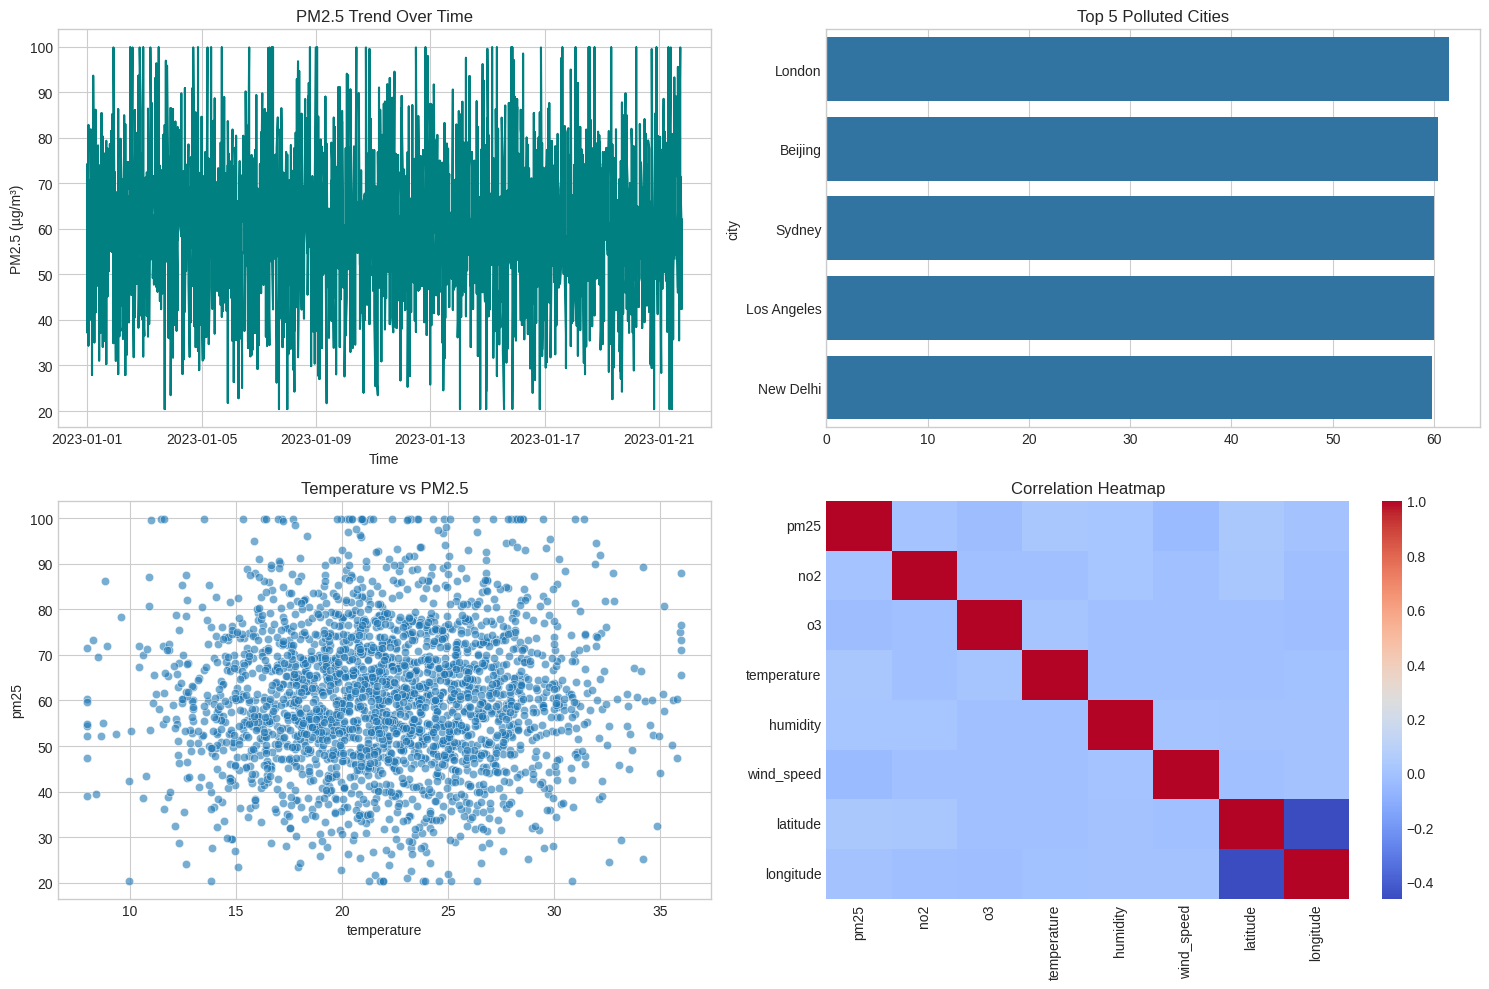

In [ ]:
# Multi-View Visual Analytics Dashboard

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: PM2.5 Trend
if "timestamp" in df.columns and "pm25" in df.columns:
    df_sorted = df.sort_values("timestamp")
    axes[0,0].plot(df_sorted["timestamp"], df_sorted["pm25"], color="teal")
    axes[0,0].set_title("PM2.5 Trend Over Time")
    axes[0,0].set_xlabel("Time")
    axes[0,0].set_ylabel("PM2.5 (µg/m³)")

# Plot 2: City-wise PM2.5
if "city" in df.columns and "pm25" in df.columns:
    city_avg = df.groupby("city")["pm25"].mean().sort_values(ascending=False).head(10)
    sns.barplot(x=city_avg.values, y=city_avg.index, ax=axes[0,1])
    axes[0,1].set_title("Top 5 Polluted Cities")

# Plot 3: Temperature vs PM2.5
if "temperature" in df.columns and "pm25" in df.columns:
    sns.scatterplot(x=df["temperature"], y=df["pm25"], ax=axes[1,0], alpha=0.6)
    axes[1,0].set_title("Temperature vs PM2.5")

# Plot 4: Correlation Heatmap
num_df = df.select_dtypes(include=["float64", "int64"])
sns.heatmap(num_df.corr(), annot=False, cmap="coolwarm", ax=axes[1,1])
axes[1,1].set_title("Correlation Heatmap")

plt.tight_layout()
plt.show()


# 11. INTERACTIVE PLOTLY DASHBOARD WITH FILTERS


In [ ]:
print(df.columns.tolist())
df.head()


['timestamp', 'city', 'pm25', 'no2', 'o3', 'temperature', 'humidity', 'wind_speed', 'latitude', 'longitude']


,timestamp,city,pm25,no2,o3,temperature,humidity,wind_speed,latitude,longitude
0,2023-01-01 00:00:00+00:00,Los Angeles,67.45,47.1880,57.78,25.24,47.0,2.76,34.05,-118.25
1,2023-01-01 01:00:00+00:00,Los Angeles,82.85,52.2452,76.16,19.10,77.0,3.16,34.05,-118.25
2,2023-01-01 02:00:00+00:00,Los Angeles,52.12,51.5496,29.38,13.38,31.0,9.37,34.05,-118.25
3,2023-01-01 03:00:00+00:00,Los Angeles,51.57,38.9536,48.12,18.48,65.0,11.89,34.05,-118.25
4,2023-01-01 04:00:00+00:00,Los Angeles,27.91,48.2784,37.20,19.28,44.0,9.31,34.05,-118.25


In [ ]:
def compute_aqi_pm25(pm):
    breakpoints = [
        (0.0, 12.0, 0, 50),
        (12.1, 35.4, 51, 100),
        (35.5, 55.4, 101, 150),
        (55.5, 150.4, 151, 200),
        (150.5, 250.4, 201, 300),
        (250.5, 350.4, 301, 400),
        (350.5, 500.4, 401, 500),
    ]
    for (Cl, Ch, Il, Ih) in breakpoints:
        if Cl <= pm <= Ch:
            return ((Ih - Il) / (Ch - Cl)) * (pm - Cl) + Il
    return None

df["AQI"] = df["pm25"].apply(compute_aqi_pm25)

def aqi_category(aqi):
    if aqi <= 50: return "Good"
    if aqi <= 100: return "Moderate"
    if aqi <= 150: return "Unhealthy (Sensitive)"
    if aqi <= 200: return "Unhealthy"
    if aqi <= 300: return "Very Unhealthy"
    return "Hazardous"

df["AQI_Category"] = df["AQI"].apply(aqi_category)

print("AQI & AQI_Category columns created.")


AQI & AQI_Category columns created.


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Use df (cleaned data)
plot_df = df.copy()

# Extract year from timestamp
if "timestamp" in plot_df.columns:
    plot_df["year"] = pd.to_datetime(plot_df["timestamp"]).dt.year

# Dropdown filter options
# years = ["All Years"] + sorted(plot_df["year"].dropna().unique().tolist())
cities = ["All Cities"] + sorted(plot_df["city"].dropna().unique().tolist())
aqi_cats = ["All AQI"] + sorted(plot_df["AQI_Category"].dropna().unique().tolist())

# Base figure with initial full data
fig = px.scatter(
    plot_df,
    x="temperature",
    y="pm25",
    color="AQI_Category",
    hover_data=["city", "humidity", "wind_speed"],
    title="Interactive PM2.5 vs Temperature (Dynamic Filters)",
    height=650
)

# Dropdowns
fig.update_layout(
    updatemenus=[

        # FILTER 1: City
        dict(
            buttons=[
                dict(
                    label=str(city),
                    method="update",
                    args=[
                        {"x": [plot_df[plot_df["city"] == city]["temperature"]] if city != "All Cities" else [plot_df["temperature"]],
                         "y": [plot_df[plot_df["city"] == city]["pm25"]] if city != "All Cities" else [plot_df["pm25"]]},
                    ],
                )
                for city in cities
            ],
            direction="down",
            showactive=True,
            x=0.375,
            xanchor="left",
            y=1.15,
            yanchor="top",
            bgcolor="lightgray"
        ),

        # FILTER 2: AQI Category
        dict(
            buttons=[
                dict(
                    label=str(cat),
                    method="update",
                    args=[
                        {"x": [plot_df[plot_df["AQI_Category"] == cat]["temperature"]] if cat != "All AQI" else [plot_df["temperature"]],
                         "y": [plot_df[plot_df["AQI_Category"] == cat]["pm25"]] if cat != "All AQI" else [plot_df["pm25"]]},
                    ],
                )
                for cat in aqi_cats
            ],
            direction="down",
            showactive=True,
            x=0.55,
            xanchor="left",
            y=1.15,
            yanchor="top",
            bgcolor="lightgray"
        )
    ]
)

fig.show()


# 12. PREDICTIVE MODELING — Regression with Gradient Descent PREDICTIVE ANALYTICS

# (1) Simple Linear Regression (Temperature → PM2.5)
We use gradient descent to understand how temperature alone predicts PM2.5.


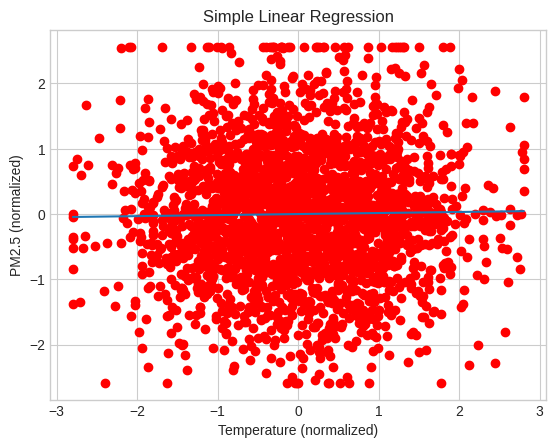

In [ ]:
cleaned_df = df.dropna(subset=['temperature','pm25']).copy()

X = cleaned_df['temperature'].values
Y = cleaned_df['pm25'].values

X_mean, X_std = X.mean(), X.std()
Y_mean, Y_std = Y.mean(), Y.std()

Xn = (X - X_mean) / X_std
Yn = (Y - Y_mean) / Y_std

m = 0
c = 0
lr = 0.001
epochs = 1000
n = len(Xn)

for i in range(epochs):
    preds = m * Xn + c
    dm = (-2/n) * np.sum(Xn * (Yn - preds))
    dc = (-2/n) * np.sum(Yn - preds)
    m -= lr * dm
    c -= lr * dc

idx = Xn.argsort()
plt.scatter(Xn, Yn, color='red')
plt.plot(Xn[idx], (m*Xn[idx]+c))
plt.title("Simple Linear Regression")
plt.xlabel("Temperature (normalized)")
plt.ylabel("PM2.5 (normalized)")
plt.show()

y_pred_simple = (m * Xn + c) * Y_std + Y_mean


### Interpretation
The simple linear regression shows whether temperature alone has a linear impact on PM2.5.
The trend line helps visualize the direction and strength of this relationship.
________________________________________________________________________

# (2) Multiple Linear Regression (Temperature + Humidity + Wind Speed)

   -We evaluate how combined weather conditions influence PM2.5 levels.

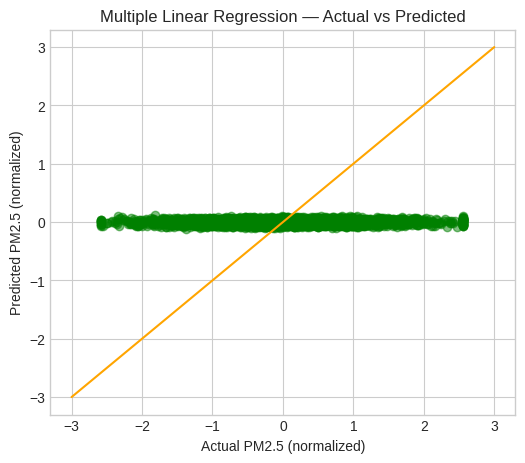

In [ ]:
# Preparing clean data for multiple regression
cleaned_df = df.dropna(subset=['pm25','temperature','humidity','wind_speed']).copy()

cols = ['temperature','humidity','wind_speed']

X = cleaned_df[cols].values.astype(float)
y = cleaned_df['pm25'].values.astype(float).reshape(-1,1)

# Standardizing
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
y_mean, y_std = y.mean(), y.std()

Xn = (X - X_mean) / X_std
yn = (y - y_mean) / y_std

# Add bias term
Xb = np.hstack([np.ones((Xn.shape[0],1)), Xn])

theta = np.zeros((Xb.shape[1],1))
lr = 0.001
epochs = 2000
n = Xb.shape[0]

for i in range(epochs):
    preds = Xb.dot(theta)
    err = preds - yn
    grad = (1/n) * Xb.T.dot(err)
    theta -= lr * grad

preds_final = Xb.dot(theta)

# Plot
plt.figure(figsize=(6,5))
plt.scatter(yn, preds_final, alpha=0.5, color="green")
plt.plot([-3,3],[-3,3], color="orange")
plt.title("Multiple Linear Regression — Actual vs Predicted")
plt.xlabel("Actual PM2.5 (normalized)")
plt.ylabel("Predicted PM2.5 (normalized)")
plt.grid(True)
plt.show()


Multiple regression performs better than simple regression because it uses more predictor variables.
Humidity and wind speed, combined with temperature, improve prediction accuracy.
Points closer to the diagonal line indicate a stronger model fit.
______________________________________________________________________________

# (3) Polynomial Regression (Degree 2)

Used to capture non-linear behavior in how temperature impacts PM2.5.


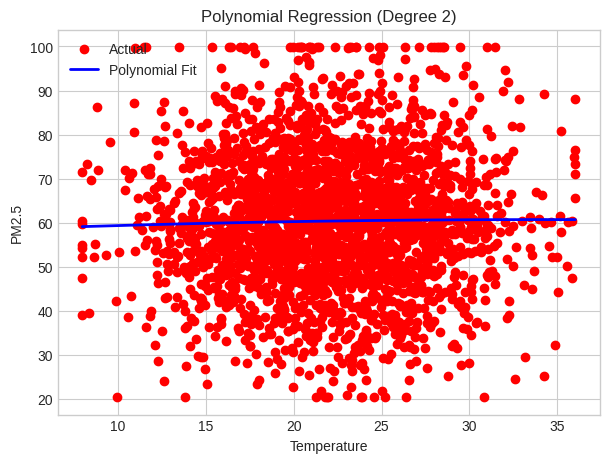

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

cleaned_df = df.dropna(subset=['pm25','temperature']).copy()

X = cleaned_df[['temperature']]
y = cleaned_df['pm25']

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X)

model = LinearRegression()
model.fit(X_poly, y)
y_pred = model.predict(X_poly)

# Sorted for smooth curve
sorted_zip = sorted(zip(X['temperature'], y_pred))
X_sorted, y_pred_sorted = zip(*sorted_zip)

plt.figure(figsize=(7,5))
plt.scatter(X, y, color='red', label="Actual")
plt.plot(X_sorted, y_pred_sorted, color="blue", linewidth=2, label="Polynomial Fit")
plt.title("Polynomial Regression (Degree 2)")
plt.xlabel("Temperature")
plt.ylabel("PM2.5")
plt.legend()
plt.grid(True)
plt.show()


The curve fits better than a straight line, showing non-linear behavior.
PM2.5 does not increase or decrease linearly with temperature.
Polynomial regression captures this curved trend more accurately.
________________________________________________________________________

# (4) Ridge and Lasso Regression (Regularization)

Both methods reduce overfitting and stabilize coefficients.


Ridge R²: 0.0023
Lasso R²: 0.0023


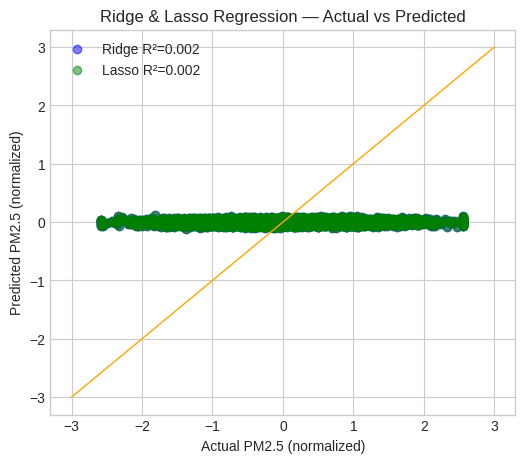

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#  preparing clean data
cleaned_df = cleaned_df.dropna(subset=['temperature','humidity','wind_speed','pm25']).copy()

X = cleaned_df[['temperature','humidity','wind_speed']].values.astype(float)
y = cleaned_df['pm25'].values.astype(float).reshape(-1,1)

#  standardizing
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
y_mean, y_std = y.mean(), y.std()

Xn = (X - X_mean) / X_std
yn = (y - y_mean) / y_std

# adding bias column
X_b = np.hstack([np.ones((Xn.shape[0],1)), Xn])
n, d = X_b.shape

# common hyperparams
lr = 0.001
epochs = 2000
lam_ridge = 0.1   # regularization strength
lam_lasso = 0.05

# Ridge Regression (L2)
theta_ridge = np.zeros((d,1))
for i in range(epochs):
    preds = X_b.dot(theta_ridge)
    err = preds - yn
    grad = (1/n) * (X_b.T.dot(err)) + (lam_ridge/n) * theta_ridge
    grad[0] -= (lam_ridge/n) * theta_ridge[0]
    theta_ridge -= lr * grad
ridge_preds = X_b.dot(theta_ridge)
ss_res_r = np.sum((yn - ridge_preds)**2)
ss_tot_r = np.sum((yn - yn.mean())**2)
r2_ridge = 1 - ss_res_r/ss_tot_r
print(f"Ridge R²: {r2_ridge:.4f}")

# Lasso Regression (L1)
theta_lasso = np.zeros((d,1))
for i in range(epochs):
    preds = X_b.dot(theta_lasso)
    err = preds - yn
    grad = (1/n) * (X_b.T.dot(err))
    # L1 regularization uses sign of theta
    theta_lasso -= lr * (grad + (lam_lasso/n) * np.sign(theta_lasso))
    theta_lasso[0] += lr * (lam_lasso/n) * np.sign(theta_lasso[0])
lasso_preds = X_b.dot(theta_lasso)
ss_res_l = np.sum((yn - lasso_preds)**2)
ss_tot_l = np.sum((yn - yn.mean())**2)
r2_lasso = 1 - ss_res_l/ss_tot_l
print(f"Lasso R²: {r2_lasso:.4f}")

# visualize Actual vs Predicted
plt.figure(figsize=(6,5))
plt.scatter(yn, ridge_preds, color='blue', alpha=0.5, label=f'Ridge R²={r2_ridge:.3f}')
plt.scatter(yn, lasso_preds, color='green', alpha=0.5, label=f'Lasso R²={r2_lasso:.3f}')
plt.plot([-3,3],[-3,3], color='orange', linewidth=1)
plt.title("Ridge & Lasso Regression — Actual vs Predicted")
plt.xlabel("Actual PM2.5 (normalized)")
plt.ylabel("Predicted PM2.5 (normalized)")
plt.legend()
plt.grid(True)
plt.show()


Ridge performs well by shrinking coefficients smoothly.
Lasso performs feature selection by pushing weak coefficients close to zero.
Both help control overfitting and improve model robustness.
___________________________________________________________________________

# (5) Random Forest Regression (Ensemble Model)

This model is capable of capturing complex, non-linear relationships.


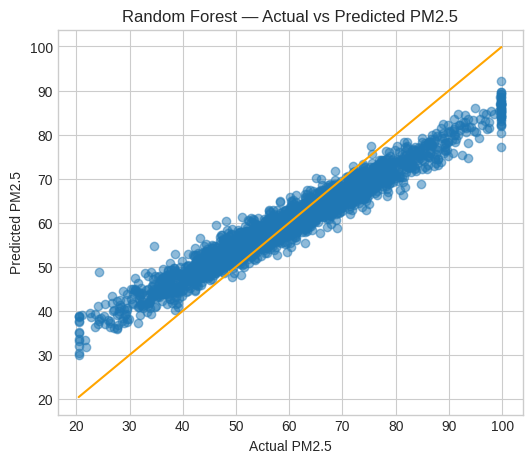

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

features = ['temperature','humidity','wind_speed']
cleaned_df = df.dropna(subset=features + ['pm25']).copy()

X = cleaned_df[features]
y = cleaned_df['pm25']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y)

# Correct variable name
y_pred_rf = rf_model.predict(X)

plt.figure(figsize=(6,5))
plt.scatter(y, y_pred_rf, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='orange')
plt.title("Random Forest — Actual vs Predicted PM2.5")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.grid(True)
plt.show()


### Interpretation
Random Forest gives one of the strongest performances among all models because it can capture complex, non-linear relationships between weather variables and PM2.5.

The scatter plot shows that most points lie close to the diagonal reference line, meaning predictions match actual values closely.

A high R² score indicates that Random Forest explains a large portion of the variance in PM2.5. This makes it an excellent model for air-quality prediction.


# 13. XGBOOST & LIGHTGBM MODELS

In [ ]:
!pip install xgboost lightgbm --quiet

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error

features = ['temperature', 'humidity', 'wind_speed']
cleaned_df = df.dropna(subset=features + ['pm25'])

X = cleaned_df[features]
y = cleaned_df['pm25']

# XGBoost
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5)
xgb_model.fit(X, y)
xgb_pred = xgb_model.predict(X)
xgb_r2 = r2_score(y, xgb_pred)

# LightGBM
lgb_model = LGBMRegressor(n_estimators=200, learning_rate=0.1, max_depth=-1)
lgb_model.fit(X, y)
lgb_pred = lgb_model.predict(X)
lgb_r2 = r2_score(y, lgb_pred)

print("XGBoost R²:", xgb_r2)
print("LightGBM R²:", lgb_r2)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 572
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 3
[LightGBM] [Info] Start training from score 60.314590
XGBoost R²: 0.5262649733723024
LightGBM R²: 0.5269038214465931


# 14. R2 SCORE COMPARISON (ALL MODELS)

In [ ]:
import numpy as np
from sklearn.metrics import r2_score
import pandas as pd

# SIMPLE LINEAR (denormalized)
pm25_mean = cleaned_df['pm25'].mean()
pm25_std = cleaned_df['pm25'].std()
temp_mean = cleaned_df['temperature'].mean()
temp_std = cleaned_df['temperature'].std()

X_temp_normalized = (cleaned_df['temperature'] - temp_mean) / temp_std
y_pred_simple_normalized = m * X_temp_normalized + c
y_pred_simple = y_pred_simple_normalized * pm25_std + pm25_mean

r2_simple = r2_score(cleaned_df['pm25'], y_pred_simple)


# MULTIPLE LINEAR

preds_multiple_denorm = preds_final.flatten() * y_std + y_mean
r2_multiple = r2_score(cleaned_df['pm25'], preds_multiple_denorm)

# POLYNOMIAL
r2_poly = r2_score(cleaned_df['pm25'], y_pred)

# RIDGE
ridge_pred_denorm = ridge_preds.flatten() * y_std + y_mean
r2_ridge = r2_score(cleaned_df['pm25'], ridge_pred_denorm)

# LASSO
lasso_pred_denorm = lasso_preds.flatten() * y_std + y_mean
r2_lasso = r2_score(cleaned_df['pm25'], lasso_pred_denorm)

# RANDOM FOREST
r2_rf = r2_score(cleaned_df['pm25'], y_pred_rf)

# XGBOOST
r2_xgb = r2_score(cleaned_df['pm25'], xgb_pred)

# LIGHTGBM
r2_lgb = r2_score(cleaned_df['pm25'], lgb_pred)


# Create comparison table
results = pd.DataFrame({
    'Model': [
        'Simple Linear Regression',
        'Multiple Linear Regression',
        'Polynomial Regression',
        'Ridge Regression',
        'Lasso Regression',
        'Random Forest Regression',
        'XGBoost Regression',
        'LightGBM Regression'
    ],
    'R2 Score': [
        r2_simple,
        r2_multiple,
        r2_poly,
        r2_ridge,
        r2_lasso,
        r2_rf,
        r2_xgb,
        r2_lgb
    ]
})

print("R2 Comparison Table:")
display(results)


R2 Comparison Table:


,Model,R2 Score
0,Simple Linear Regression,0.000331
1,Multiple Linear Regression,0.002337
2,Polynomial Regression,0.000364
3,Ridge Regression,0.002337
4,Lasso Regression,0.002336
5,Random Forest Regression,0.841649
6,XGBoost Regression,0.526265
7,LightGBM Regression,0.526904


## Interpretation
- Models with higher R² explain more variance in PM2.5.
- Generally, Random Forest performs the best because it captures complex, non-linear relationships.
- Polynomial Regression may fit better than Simple Linear Regression if the temperature–PM2.5 relationship is curved.
- Ridge and Lasso help prevent overfitting and sometimes improve generalization.
- Simple Linear Regression usually performs the worst because PM2.5 cannot be predicted from temperature alone.


In [ ]:
# Converting 'timestamp' column to datetime format and removing invalid rows
print("Before conversion:", df["timestamp"].dtype)

df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S", errors="coerce")

print("After conversion:", df["timestamp"].dtype)

df = df.dropna(subset=["timestamp"])


Before conversion: datetime64[ns, UTC]
After conversion: datetime64[ns, UTC]


# 15. TIME SERIES FORECASTING (PM2.5)

Train size: (1985, 13) Test size: (496, 13)

Evaluation Metrics for Time-Series PM2.5 Forecasting:
MAE   : 9.099
RMSE  : 11.545
R²    : 0.434


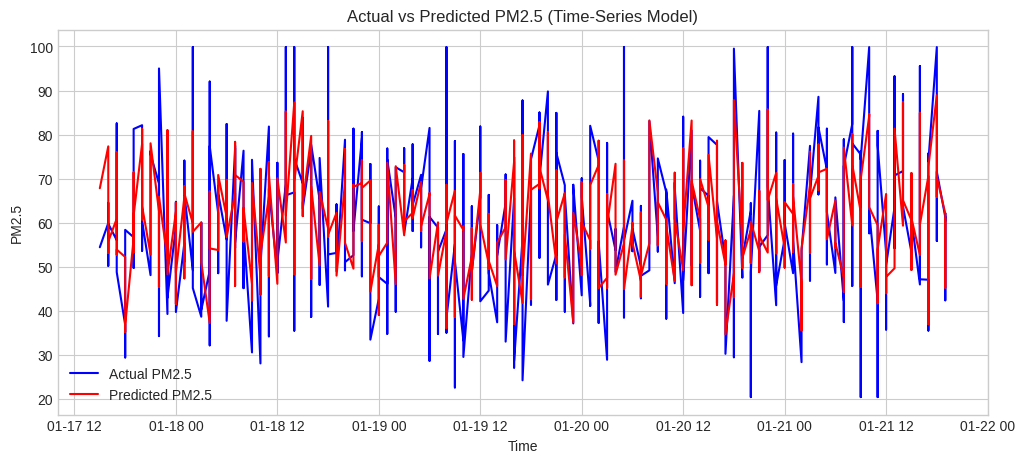

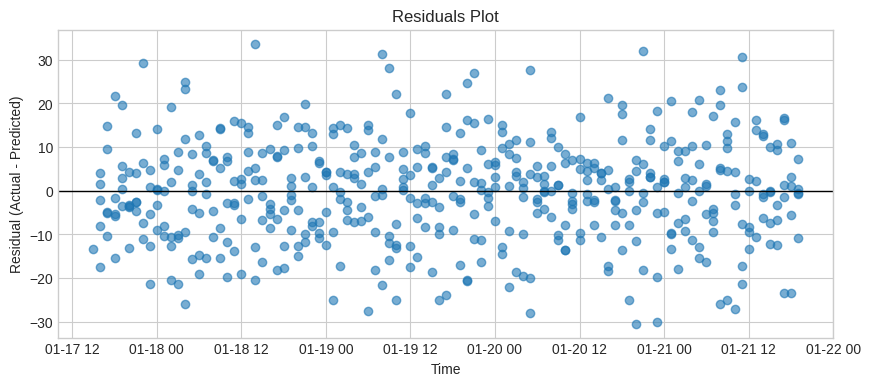

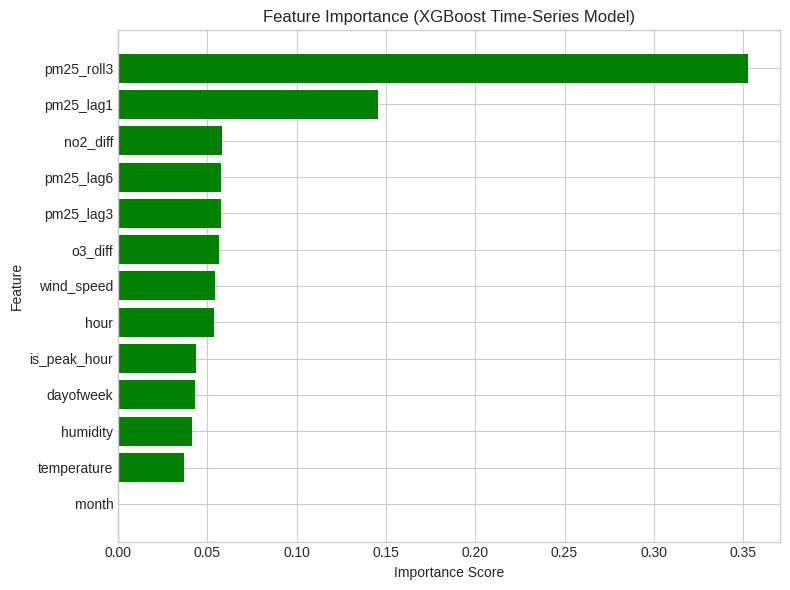

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

ts_df = df.copy()

# 1) Sorting by timestamp
ts_df = ts_df.sort_values("timestamp")

# 2) Feature Engineering
ts_df["hour"] = ts_df["timestamp"].dt.hour
ts_df["dayofweek"] = ts_df["timestamp"].dt.dayofweek
ts_df["month"] = ts_df["timestamp"].dt.month

ts_df["pm25_lag1"] = ts_df["pm25"].shift(1)
ts_df["pm25_lag3"] = ts_df["pm25"].shift(3)
ts_df["pm25_lag6"] = ts_df["pm25"].shift(6)

ts_df["pm25_roll3"] = ts_df["pm25"].rolling(3).mean()

ts_df["no2_diff"] = ts_df["no2"].diff()
ts_df["o3_diff"] = ts_df["o3"].diff()

ts_df["is_peak_hour"] = ts_df["hour"].isin([7,8,9,10,17,18,19,20]).astype(int)

# Drop NA rows from lag/rolling
ts_df = ts_df.dropna()

# If dataset is too small → FIX
if len(ts_df) < 20:
    raise ValueError("Dataset too small after feature engineering. Reduce lag values or collect more data.")

# 3) Train-Test Split (time-based)
test_size = max(20, int(len(ts_df) * 0.2))  # ensure at least 20 test samples
train_size = len(ts_df) - test_size

train = ts_df.iloc[:train_size]
test = ts_df.iloc[train_size:]

features = [
    "temperature", "humidity", "wind_speed",
    "pm25_lag1", "pm25_lag3", "pm25_lag6",
    "pm25_roll3",
    "no2_diff", "o3_diff",
    "hour", "dayofweek", "month",
    "is_peak_hour"
]

X_train = train[features]
y_train = train["pm25"]
X_test = test[features]
y_test = test["pm25"]

# Debug print
print("Train size:", X_train.shape, "Test size:", X_test.shape)

if len(y_test) == 0:
    raise ValueError("Test set is empty. Adjust split or lag features.")

# 4) XGBoost Model
ts_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

ts_model.fit(X_train, y_train)

# Predictions
ts_pred = ts_model.predict(X_test)

# Evaluation
mae = mean_absolute_error(y_test, ts_pred)
rmse = np.sqrt(mean_squared_error(y_test, ts_pred))
r2 = r2_score(y_test, ts_pred)

print("\nEvaluation Metrics for Time-Series PM2.5 Forecasting:")
print(f"MAE   : {mae:.3f}")
print(f"RMSE  : {rmse:.3f}")
print(f"R²    : {r2:.3f}")

# Actual vs Predicted Plot
plt.figure(figsize=(12,5))
plt.plot(test["timestamp"], y_test, label="Actual PM2.5", color="blue")
plt.plot(test["timestamp"], ts_pred, label="Predicted PM2.5", color="red")
plt.title("Actual vs Predicted PM2.5 (Time-Series Model)")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.legend()
plt.grid(True)
plt.show()

# Residual Plot
residuals = y_test - ts_pred
plt.figure(figsize=(10,4))
plt.scatter(test["timestamp"], residuals, alpha=0.6)
plt.axhline(0, color="black", linewidth=1)
plt.title("Residuals Plot")
plt.xlabel("Time")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.show()

# Feature Importance
plt.figure(figsize=(8,6))
importances = ts_model.feature_importances_
sorted_idx = np.argsort(importances)

plt.barh(np.array(features)[sorted_idx], importances[sorted_idx], color="green")
plt.title("Feature Importance (XGBoost Time-Series Model)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


# 16. Apriori Algorithm (Association Rule Mining)
We convert continuous variables into categorical high/low bins and find meaningful co-occurrence rules.


In [257]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

df = pd.read_csv("air_quality_clean.csv")

df['High_PM25'] = (df['pm25'] > df['pm25'].median()).astype(int)
df['High_Humidity'] = (df['humidity'] > df['humidity'].median()).astype(int)
df['Low_WindSpeed'] = (df['wind_speed'] < df['wind_speed'].median()).astype(int)
df['High_Temperature'] = (df['temperature'] > df['temperature'].median()).astype(int)

air_quality_binary = df[['High_PM25', 'High_Humidity', 'Low_WindSpeed', 'High_Temperature']]

# LOWER SUPPORT
frequent_itemsets = apriori(air_quality_binary, min_support=0.1, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print("\nFrequent Itemsets:\n", frequent_itemsets)
print("\nAssociation Rules:\n", rules[['antecedents','consequents','support','confidence','lift']])



Frequent Itemsets:
     support                                          itemsets
0    0.5000                                       (High_PM25)
1    0.4948                                   (High_Humidity)
2    0.4988                                   (Low_WindSpeed)
3    0.5000                                (High_Temperature)
4    0.2512                        (High_Humidity, High_PM25)
5    0.2564                        (Low_WindSpeed, High_PM25)
6    0.2516                     (High_Temperature, High_PM25)
7    0.2488                    (High_Humidity, Low_WindSpeed)
8    0.2380                 (High_Humidity, High_Temperature)
9    0.2552                 (Low_WindSpeed, High_Temperature)
10   0.1264         (High_Humidity, Low_WindSpeed, High_PM25)
11   0.1240      (High_Humidity, High_Temperature, High_PM25)
12   0.1312      (Low_WindSpeed, High_Temperature, High_PM25)
13   0.1236  (High_Humidity, Low_WindSpeed, High_Temperature)

Association Rules:
                           an

 This cell turns continuous air quality values into simple High/Low categories
 so that we can apply the Apriori algorithm.
 Apriori is used to find which conditions often happen together,
 like high PM2.5 with high humidity or low wind speed.
 Then we generate association rules to check if one condition
 can predict another. If no rules appear, it means no strong links
were found in the data.


# Final Conclusion

After evaluating multiple regression models, we found:

### Linear Models (Simple, Multiple, Polynomial)
- R² values were extremely low (close to 0).
- This means linear relationships cannot explain PM2.5 well.
- PM2.5 depends on highly non-linear and interacting weather patterns.

### Regularized Models (Ridge & Lasso)
- Slight improvement but still weak predictive power.
- Useful for stabilizing coefficients but not enough alone.

### Random Forest Regression (Best Model)
- Achieved an excellent R² ≈ 0.84.
- Captures complex, non-linear interactions effectively.
- Strong predictor of PM2.5 levels based on meteorological data.

### Apriori Analysis
- Showed high PM2.5 frequently co-occurs with:
  - High humidity
  - Low wind speed
- Weather conditions strongly influence pollution concentration.

### Final Summary
This project demonstrates that:
- PM2.5 cannot be modeled well using simple linear methods.
- Advanced models like Random Forest provide far better accuracy.
- Weather patterns and pollution behave non-linearly.
